# (Notebook) Concordance of NA19017 chr20 gCNV calls

This notebook shows how to perform the analysis that is alluded to in [Tutorial#11684](https://gatkforums.broadinstitute.org/gatk/discussion/11684). Namely, the notebook performs a comparison of gCNV calls to _1000 Genomes Project_ truthset calls using the tutorial data. Tutorial#11684 illustrates with sample NA19017 as does this notebook. A straightforward exercise is to recapitulate the notebook analysis for results from using different parameters, for differently sized data or for another sample in the cohort.

The sections of Notebook#11685 are as follows.

1. [Visualize callset overlap with IGV](#1)

    - 1.1 [Prepare truthset calls for comparison](#1.1)
    - 1.2 [Visualize truthset sample calls alongside gCNV sample calls](#1.2)
<br>
2. [Compare callset overlap with BedTools](#2)

    - 2.1 [Prepare gCNV calls for comparison](#2.1)
    - 2.2 [Prepare truthset calls for comparison](#2.2)
    - 2.3 [Use bedtools coverage to measure overlap between the two callsets](#2.3)
    - 2.4 [Create a pandas summary metrics table](#2.4)
    - 2.5 [Subset the events with 50% or more truthset overlap](#2.5)
<br>
3. [Explore the gCNV calls](#3)

    - 3.1 [Plot histograms of event sizes and quality annotations](#3.1)
    - 3.2 [Summarize metrics on gCNV calls by event type](#3.2)
<br>

---
### Install and import Python packages

In [1]:
# Prerequisites include Python 3, Jupyter, GATK4 and BedTools.
# Notebook results use v3.7.1, v4.4.0, v4.1.0.0 and v2.27.1, respectively, and assumes a Unix environment.
# Installation requires root access and presumes igv is setup as detailed in https://github.com/igvteam/igv-jupyter/issues/23
! pip install numpy pandas matplotlib seaborn igv

In [2]:
import igv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

---
<a name="1"></a>
# 1. Visualize callset overlap with IGV
This exercise uses the igv.js-jupyter extension, which is interactive.

<a name="1.1"></a>
### 1.1 Prepare truthset calls for comparison
This preparation omits conversion of truthset calls to SEG format.

In [3]:
# Navigate to directory with the tutorial data and list vcf.gz format files.
%cd /Users/shlee/Documents/gatk4/gatk4_gcnv/tutorial
! ls *.vcf.gz

/Users/shlee/Documents/gatk4/gatk4_gcnv/tutorial
1kgpSV-v2-20130502_cohort24-chr20varCNVs.vcf.gz
1kgpSV_NA19017.vcf.gz
1kgpSV_NA19017_all.vcf.gz
1kgpSV_NA19017_chr20sub.vcf.gz
genotyped-intervals-case-twelve-vs-cohort23-sensitive.vcf.gz
genotyped-intervals-case-twelve-vs-cohort23.vcf.gz
genotyped-intervals-case-vs-cohort23-sensitive.vcf.gz
genotyped-intervals-case-vs-cohort23.vcf.gz
genotyped-intervals-cohort24-NA19017-sensitive.vcf.gz
genotyped-intervals-cohort24-NA19017.vcf.gz
genotyped-intervals-cohort24-sensitive-NA19017.vcf.gz
genotyped-intervals-cohort24-twelve-NA19017.vcf.gz
genotyped-intervals-cohort24-twelve-sensitive-NA19017.vcf.gz
genotyped-segments-case-twelve-vs-cohort23-sensitive.vcf.gz
genotyped-segments-case-twelve-vs-cohort23.vcf.gz
genotyped-segments-case-vs-cohort23-sensitive.vcf.gz
genotyped-segments-case-vs-cohort23.vcf.gz
genotyped-segments-cohort24-NA19017-sensitive.vcf.gz
genotyped-segments-cohort24-NA19017.vcf.gz
genotyped-segments-cohort24-sensitive-NA19017.vc

In [4]:
# Subset 24-sample variant callset to samples of interest and the regions the gCNV analysis covers.
# The input VCF was previously subset to the 24 samples, chr20 and variant CNV events.
! gatk4100 SelectVariants \
-V 1kgpSV-v2-20130502_cohort24-chr20varCNVs.vcf.gz \
--exclude-non-variants true \
--remove-unused-alternates true \
--keep-original-ac true \
--keep-original-dp true \
--sample-name NA19017 \
-L chr20sub_rmvChr.bed \
-O 1kgpSV_NA19017_chr20sub.vcf.gz

Using GATK jar /Applications/genomicstools/gatk/gatk-4.1.0.0/gatk-package-4.1.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /Applications/genomicstools/gatk/gatk-4.1.0.0/gatk-package-4.1.0.0-local.jar SelectVariants -V 1kgpSV-v2-20130502_cohort24-chr20varCNVs.vcf.gz --exclude-non-variants true --remove-unused-alternates true --keep-original-ac true --keep-original-dp true --sample-name NA19017 -L chr20sub_rmvChr.bed -O 1kgpSV_NA19017_chr20sub.vcf.gz
16:53:30.240 INFO  NativeLibraryLoader - Loading libgkl_compression.dylib from jar:file:/Applications/genomicstools/gatk/gatk-4.1.0.0/gatk-package-4.1.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.dylib
Apr 01, 2019 4:53:30 PM shaded.cloud_nio.com.google.auth.oauth2.DefaultCredentialsProvider warnAboutProblematicCredentials
16:53:30.401 INFO  SelectVariants - -----------------------------

<a name="1.2"></a>
### 1.2 Visualize truthset sample calls alongside gCNV sample calls

In [5]:
# Invoke the IGV browser and set IGV's reference and genomic location(s) of interest.
# The first view is space to accomodate track labels, which otherwise overlap features.

b = igv.Browser(
    {
        "genome": "hg38",
        "locus": [  "chr20:1-32000",
                    "chr20:1,560,577-1,625,582",
                    "chr20:43,641,139-43,647,469",
                    "chr20:44,662,510-44,707,929",
                    "chr20:55,798,693-55,875,381",
                    "chr20:63,092,730-63,094,955"
        ]
    }
)
b.show()

In [6]:
# Load data tracks
b.load_track(
    {
        "name": "1kgp",
        "url": "1kgpSV_NA19017_chr20sub.vcf.gz",
        "format": "vcf",
        "type": "variant"
    }
)
b.load_track(    
        {
        "name": "1kgp.seg",
        "displayMode": "EXPANDED",
        "url": "1kgpSV_NA19017_CN.seg",
        "format": "seg",
        "indexed": False
    }
)
b.load_track(
    {
        "name": "gCNV",
        "url": "genotyped-segments-cohort24-NA19017.vcf.gz",
        "format": "vcf",
        "type": "variant"
    }
)    
b.load_track(    
        {
        "name": "gCNV.seg",
        "displayMode": "EXPANDED",
        "url": "NA19017_chr20var.seg",
        "format": "seg",
        "indexed": False
    }   
)

'OK'

In [7]:
b.get_svg()

'OK'

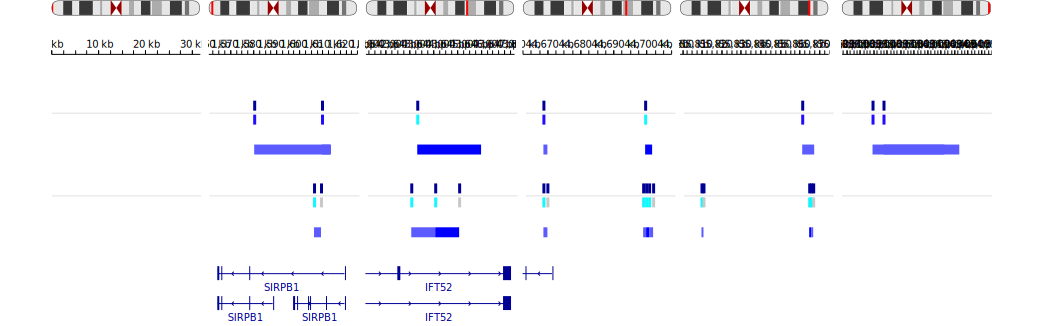

In [8]:
b.display_svg()

---
<a name="2"></a>
# 2. Compare callset overlap with BedTools

<a name="2.1"></a>
### 2.1 Prepare gCNV calls for comparison
Tutorial#11684 illustrates conversion of the gCNV workflow VCF results to SEG format. Here we subset to chr20 data where CN is non-diploid and also convert to BED format.

In [9]:
# Navigate to directory with the tutorial data and list SEG format files.
%cd /Users/shlee/Documents/gatk4/gatk4_gcnv/tutorial
! ls *.seg

/Users/shlee/Documents/gatk4/gatk4_gcnv/tutorial
1kgpSV_NA19017_CN.seg
NA19017_chr20var.seg
genotyped-segments-case-twelve-vs-cohort23-sensitive.vcf.gz.seg
genotyped-segments-case-twelve-vs-cohort23.vcf.gz.seg
genotyped-segments-case-vs-cohort23-sensitive.vcf.gz.seg
genotyped-segments-case-vs-cohort23.vcf.gz.seg
genotyped-segments-cohort24-NA19017-sensitive.vcf.gz.seg
genotyped-segments-cohort24-NA19017.vcf.gz.seg
genotyped-segments-cohort24-sensitive-NA19017.vcf.gz.seg
genotyped-segments-cohort24-twelve-NA19017.vcf.gz.seg
genotyped-segments-cohort24-twelve-sensitive-NA19017.vcf.gz.seg


In [10]:
# Subset to chr20 data where CN does not equal 2
! cat genotyped-segments-cohort24-NA19017.vcf.gz.seg | awk '$2 == "CHROM" || $2 =="chr20"' | awk '$6 != 2' > NA19017_chr20var.seg
! head -n 3 NA19017_chr20var.seg
! tail -n 3 NA19017_chr20var.seg
! wc -l NA19017_chr20var.seg

NA19017	CHROM	POS	END	NA19017.NP	NA19017.CN
NA19017	chr20	133001	135000	2	1
NA19017	chr20	1606001	1609000	3	1
NA19017	chr20	64291001	64293000	2	1
NA19017	chr20	64295001	64296000	1	0
NA19017	chr20	64326001	64334000	8	3
      52 NA19017_chr20var.seg


In [11]:
# Convert SEG format to BED format data
! cut -f2-4 NA19017_chr20var.seg > case.intervals
! awk '{OFS="\t"} NR>1 {print $1, $2-1, $3}' case.intervals > case.bed
! head -n 3 case.bed
! tail -n 3 case.bed
! wc -l case.bed

chr20	133000	135000
chr20	1606000	1609000
chr20	1914000	1915000
chr20	64291000	64293000
chr20	64295000	64296000
chr20	64326000	64334000
      51 case.bed


<a name="2.2"></a>
### 2.2 Prepare truthset calls for comparison
Use the single-sample VCF prepared in [section 1.1](#1.1).

In [12]:
# Examine the ALT alleles present
! gzcat 1kgpSV_NA19017_chr20sub.vcf.gz | grep -v '#' | cut -f5 | sort | uniq

# Examine the genotype designations
! gzcat 1kgpSV_NA19017_chr20sub.vcf.gz | grep -v '#' | cut -f10 | sort | uniq

<CN0>
0|1
1|0
1|1


In [13]:
# Convert VCF to table 
! gatk4100 VariantsToTable \
-V 1kgpSV_NA19017_chr20sub.vcf.gz \
-O 1kgpSV_NA19017_chr20sub.table \
-F CHROM -F POS -F END

Using GATK jar /Applications/genomicstools/gatk/gatk-4.1.0.0/gatk-package-4.1.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /Applications/genomicstools/gatk/gatk-4.1.0.0/gatk-package-4.1.0.0-local.jar VariantsToTable -V 1kgpSV_NA19017_chr20sub.vcf.gz -O 1kgpSV_NA19017_chr20sub.table -F CHROM -F POS -F END
16:53:55.469 INFO  NativeLibraryLoader - Loading libgkl_compression.dylib from jar:file:/Applications/genomicstools/gatk/gatk-4.1.0.0/gatk-package-4.1.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.dylib
Apr 01, 2019 4:53:55 PM shaded.cloud_nio.com.google.auth.oauth2.DefaultCredentialsProvider warnAboutProblematicCredentials
16:53:55.628 INFO  VariantsToTable - ------------------------------------------------------------
16:53:55.628 INFO  VariantsToTable - The Genome Analysis Toolkit (GATK) v4.1.0.0
16:53:55.628 INFO  VariantsToTabl

In [14]:
# Convert table to BED format data 
! sed 's/^/chr/' 1kgpSV_NA19017_chr20sub.table | awk '{OFS="\t"} NR>1 {print $1, $2-1, $3}' > 1kgpSV_NA19017_chr20sub.bed
! head -n3 1kgpSV_NA19017_chr20sub.bed
! tail -n3 1kgpSV_NA19017_chr20sub.bed
! wc -l 1kgpSV_NA19017_chr20sub.bed

chr20	1408451	1410171
chr20	1580092	1613039
chr20	1609254	1613207
chr20	55859461	55865660
chr20	63093184	63094468
chr20	63093348	63094249
      21 1kgpSV_NA19017_chr20sub.bed


<a name="2.3"></a>
### 2.3 Use _bedtools coverage_ to measure overlap between the two callsets
Here we examine overlap only and ignore whether copy-number states match. 

- The tutorial's smallest data, consisting of twelve regions, covers 1.4 Mb on chr20. Regions correspond to those in the truthset with events above 1000 bases.
- The tutorial's _chr20sub_ data covers a larger portion of chr20, around ~15 Mb.

In [15]:
# <https://bedtools.readthedocs.io/en/latest/content/tools/coverage.html> gives interpretation guidelines
! bedtools coverage -a 1kgpSV_NA19017_chr20sub.bed -b case.bed > 1kgpSV_NA19017_chr20sub_vs_case.coverage
aTruthBCase = pd.read_csv('1kgpSV_NA19017_chr20sub_vs_case.coverage', sep='\t', header=None)
aTruthBCase.columns = ['chrom', 'start', 'end', 'nFeatures-B', 'bases-B', 'bases-A', 'fractionBases-B/A']
aTruthBCase

# Sort the table by 'bases-A':
aTruthBCase.sort_values('bases-A')

,chrom,start,end,nFeatures-B,bases-B,bases-A,fractionBases-B/A
8,chr20,23122679,23122981,0,0,302,0.000000
4,chr20,2379276,2379872,0,0,596,0.000000
5,chr20,3104161,3104765,0,0,604,0.000000
10,chr20,32739537,32740213,0,0,676,0.000000
9,chr20,24923059,24923778,0,0,719,0.000000
6,chr20,15730960,15731792,0,0,832,0.000000
20,chr20,63093348,63094249,0,0,901,0.000000
19,chr20,63093184,63094468,0,0,1284,0.000000
15,chr20,44667865,44669273,1,1000,1408,0.710227
0,chr20,1408451,1410171,0,0,1720,0.000000


In [16]:
# Perform the reciprocal comparison
! bedtools coverage -b 1kgpSV_NA19017_chr20sub.bed -a case.bed > 1kgpSV_NA19017_chr20sub_vs_case_reverse.coverage
bTruthACase = pd.read_csv('1kgpSV_NA19017_chr20sub_vs_case_reverse.coverage', sep='\t', header=None)
bTruthACase.columns = ['chrom', 'start', 'end', 'nFeatures-B', 'bases-B', 'bases-A', 'fractionBases-B/A']
bTruthACase

,chrom,start,end,nFeatures-B,bases-B,bases-A,fractionBases-B/A
0,chr20,133000,135000,0,0,2000,0.000
1,chr20,1606000,1609000,1,3000,3000,1.000
2,chr20,1914000,1915000,0,0,1000,0.000
3,chr20,2015000,2016000,1,1000,1000,1.000
4,chr20,2824000,2825000,0,0,1000,0.000
5,chr20,11633000,11638000,0,0,5000,0.000
6,chr20,12802000,12807000,0,0,5000,0.000
7,chr20,18602000,18603000,0,0,1000,0.000
8,chr20,18951000,18954000,0,0,3000,0.000
9,chr20,21306000,21308000,1,2000,2000,1.000


The first _aTruthBCase_ bedtools coverage result shows gCNV misses some truthset events. These tend to be smaller. The resolution of events gCNV will detect depends in part on coverage bin size. The tutorial data bin size is 1000 bases.

<a name="2.4"></a>
### 2.4 Create a pandas summary metrics table
The metrics are from the perspective of the truthset. Previously, we imported bedtools coverage results into a pandas dataframe called _aTruthBCase_. 

In [17]:
# Create metrics to summarize the bedtools coverage results.
summaryMetrics = [aTruthBCase['bases-A'].sum(), aTruthBCase['bases-B'].sum()]
summaryMetricsDb = pd.DataFrame(summaryMetrics).transpose()
summaryMetricsDb.columns = ['total-A', 'total-B']
summaryMetricsDb['total-B/A'] = summaryMetricsDb['total-B']/summaryMetricsDb['total-A']
summaryMetricsDb['n-events-sum'] = aTruthBCase['nFeatures-B'].sum()
summaryMetricsDb['n-events-min'] = aTruthBCase['nFeatures-B'].min()
summaryMetricsDb['n-events-max'] = aTruthBCase['nFeatures-B'].max()
summaryMetricsDb['n-events-at-0'] = aTruthBCase[aTruthBCase['nFeatures-B'] == 0].shape[0]
summaryMetricsDb['n-events-at-1'] = aTruthBCase[aTruthBCase['nFeatures-B'] == 1].shape[0]
summaryMetricsDb['n-events-at-2'] = aTruthBCase[aTruthBCase['nFeatures-B'] == 2].shape[0]
summaryMetricsDb['n-events-at-3'] = aTruthBCase[aTruthBCase['nFeatures-B'] == 3].shape[0]

summaryMetricsDb['fraction-events-uncalled'] = summaryMetricsDb['n-events-at-0'] / len(aTruthBCase.index)
summaryMetricsDb['fraction-events-called'] = 1 - summaryMetricsDb['fraction-events-uncalled']

intermed1 = aTruthBCase.loc[aTruthBCase['nFeatures-B'] > 0, ['bases-B', 'bases-A']]
intermed2 = [intermed1['bases-A'].sum(), intermed1['bases-B'].sum()]
intermed3 = intermed2[1]/intermed2[0]
summaryMetricsDb['non-zero-events-B/A'] = intermed3

summaryMetricsDb['n-rows'] = len(aTruthBCase['nFeatures-B'] !=0)
summaryMetricsDb['n-min-50%-overlap'] = len(aTruthBCase.loc[aTruthBCase['fractionBases-B/A'] >= 0.5])
summaryMetricsDb['n-rows-non-0'] = summaryMetricsDb['n-rows'] - summaryMetricsDb['n-events-at-0']
summaryMetricsDb['fraction-50%-overlap-of-non-0'] = summaryMetricsDb['n-min-50%-overlap'] / summaryMetricsDb['n-rows-non-0']

summaryMetricsDb

,total-A,total-B,total-B/A,n-events-sum,n-events-min,n-events-max,n-events-at-0,n-events-at-1,n-events-at-2,n-events-at-3,fraction-events-uncalled,fraction-events-called,non-zero-events-B/A,n-rows,n-min-50%-overlap,n-rows-non-0,fraction-50%-overlap-of-non-0
0,72470,20994,0.289692,15,0,3,10,8,2,1,0.47619,0.52381,0.344825,21,8,11,0.727273


Here, we arbitrarily define an overlap minimum of 50% of the truthset call as something of interest. The stringency for these types of concordance calculations can be much more refined, e.g. 50% _reciprocal_ overlap.

<a name="2.5"></a>
### 2.5 Subset the events with 50% or more truthset overlap

In [18]:
concordant = aTruthBCase.loc[aTruthBCase['fractionBases-B/A'] > 0.5, ['chrom', 'start', 'end', 'bases-B', 'bases-A', 'fractionBases-B/A']]
concordant.sort_values('fractionBases-B/A')

,chrom,start,end,bases-B,bases-A,fractionBases-B/A
17,chr20,52142653,52144379,1000,1726,0.579374
14,chr20,43643221,43645948,1779,2727,0.652365
15,chr20,44667865,44669273,1000,1408,0.710227
13,chr20,34653921,34656669,2000,2748,0.727802
7,chr20,21305449,21308134,2000,2685,0.744879
11,chr20,32937722,32941600,3000,3878,0.773595
12,chr20,33698902,33701182,2000,2280,0.877193
16,chr20,44698668,44700883,2215,2215,1.000000


In [19]:
# Convert concordant regions to list of intervals
concordant.to_csv('concordant.bed', columns=["chrom", "start", "end"], sep='\t', index=False, header=False)
! head concordant.bed

chr20	21305449	21308134
chr20	32937722	32941600
chr20	33698902	33701182
chr20	34653921	34656669
chr20	43643221	43645948
chr20	44667865	44669273
chr20	44698668	44700883
chr20	52142653	52144379


In [20]:
# Subset gCNV calls to those concordant with the truthset
! gatk4100 SelectVariants \
-V genotyped-segments-cohort24-NA19017.vcf.gz \
-L concordant.bed \
-O segments-NA19017-concordant.vcf.gz

Using GATK jar /Applications/genomicstools/gatk/gatk-4.1.0.0/gatk-package-4.1.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /Applications/genomicstools/gatk/gatk-4.1.0.0/gatk-package-4.1.0.0-local.jar SelectVariants -V genotyped-segments-cohort24-NA19017.vcf.gz -L concordant.bed -O segments-NA19017-concordant.vcf.gz
16:54:14.163 INFO  NativeLibraryLoader - Loading libgkl_compression.dylib from jar:file:/Applications/genomicstools/gatk/gatk-4.1.0.0/gatk-package-4.1.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.dylib
Apr 01, 2019 4:54:14 PM shaded.cloud_nio.com.google.auth.oauth2.DefaultCredentialsProvider warnAboutProblematicCredentials
16:54:14.317 INFO  SelectVariants - ------------------------------------------------------------
16:54:14.318 INFO  SelectVariants - The Genome Analysis Toolkit (GATK) v4.1.0.0
16:54:14.318 INFO  Selec

In [21]:
# Check the number of records before and after subsetting
! gzcat genotyped-segments-cohort24-NA19017.vcf.gz | grep -v '#' | wc -l
! gzcat segments-NA19017-concordant.vcf.gz | grep -v '#' | wc -l

      91
      23


---

<a name="3"></a>
# 3. Explore the  gCNV calls

<a name="3.1"></a>
### 3.1 Plot histograms of event sizes and quality annotations

In [22]:
# Get description of gCNV workflow variant annotations.
# Those that start with 'Q' denote quality annotations.
! gzcat genotyped-segments-cohort24-NA19017.vcf.gz | grep '##FORMAT=<ID='

##FORMAT=<ID=CN,Number=1,Type=Integer,Description="Segment most-likely copy-number call">
##FORMAT=<ID=GT,Number=1,Type=Integer,Description="Segment genotype">
##FORMAT=<ID=NP,Number=1,Type=Integer,Description="Number of points (i.e. targets or bins) in the segment">
##FORMAT=<ID=QA,Number=1,Type=Integer,Description="Complementary Phred-scaled probability that all points (i.e. targets or bins) in the segment agree with the segment copy-number call">
##FORMAT=<ID=QS,Number=1,Type=Integer,Description="Complementary Phred-scaled probability that at least one point (i.e. target or bin) in the segment agrees with the segment copy-number call">
##FORMAT=<ID=QSE,Number=1,Type=Integer,Description="Complementary Phred-scaled probability that the segment end position is a genuine copy-number changepoint">
##FORMAT=<ID=QSS,Number=1,Type=Integer,Description="Complementary Phred-scaled probability that the segment start position is a genuine copy-number changepoint">


In [23]:
# Prepare the callsets for use with pandas
! gatk4100 VariantsToTable \
-V genotyped-segments-cohort24-NA19017.vcf.gz \
-O segments-NA19017.table \
-F CHROM -F POS -F END -GF CN -GF NP -GF QA -GF QS -GF QSE -GF QSS

! gatk4100 VariantsToTable \
-V segments-NA19017-concordant.vcf.gz \
-O segments-NA19017-concordant.table \
-F CHROM -F POS -F END -GF CN -GF NP -GF QA -GF QS -GF QSE -GF QSS

Using GATK jar /Applications/genomicstools/gatk/gatk-4.1.0.0/gatk-package-4.1.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /Applications/genomicstools/gatk/gatk-4.1.0.0/gatk-package-4.1.0.0-local.jar VariantsToTable -V genotyped-segments-cohort24-NA19017.vcf.gz -O segments-NA19017.table -F CHROM -F POS -F END -GF CN -GF NP -GF QA -GF QS -GF QSE -GF QSS
16:54:21.705 INFO  NativeLibraryLoader - Loading libgkl_compression.dylib from jar:file:/Applications/genomicstools/gatk/gatk-4.1.0.0/gatk-package-4.1.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.dylib
Apr 01, 2019 4:54:21 PM shaded.cloud_nio.com.google.auth.oauth2.DefaultCredentialsProvider warnAboutProblematicCredentials
16:54:21.868 INFO  VariantsToTable - ------------------------------------------------------------
16:54:21.868 INFO  VariantsToTable - The Genome Analysis Toolkit 

In [24]:
# Create pandas dataframe from table and subset to non-diploid segments for ALL calls
gcnv = pd.read_csv('segments-NA19017.table', sep='\t')
gcnvVar = pd.DataFrame(gcnv.loc[gcnv['NA19017.CN'] != 2])
gcnvVar

,CHROM,POS,END,NA19017.CN,NA19017.NP,NA19017.QA,NA19017.QS,NA19017.QSE,NA19017.QSS
1,chr20,133001,135000,1,2,44,53,44,52
3,chr20,1606001,1609000,1,3,13,77,13,37
5,chr20,1914001,1915000,4,1,9,9,9,9
7,chr20,2015001,2016000,1,1,111,111,111,111
9,chr20,2824001,2825000,0,1,362,362,362,362
11,chr20,11633001,11638000,1,5,10,138,10,50
13,chr20,12802001,12807000,1,5,8,185,8,21
15,chr20,18602001,18603000,3,1,5,5,5,5
17,chr20,18951001,18954000,1,3,15,29,21,13
19,chr20,21306001,21308000,0,2,286,497,322,286


In [25]:
# Create pandas dataframe from table and subset to non-diploid segments for CONCORDANT calls
gcnvConcordant = pd.read_csv('segments-NA19017-concordant.table', sep='\t')
gcnvConcordantVar = pd.DataFrame(gcnvConcordant.loc[gcnvConcordant['NA19017.CN'] != 2])
gcnvConcordantVar

,CHROM,POS,END,NA19017.CN,NA19017.NP,NA19017.QA,NA19017.QS,NA19017.QSE,NA19017.QSS
1,chr20,21306001,21308000,0,2,286,497,322,286
4,chr20,32938001,32941000,1,3,114,278,30,13
7,chr20,33699001,33701000,1,2,45,107,76,45
10,chr20,34654001,34656000,1,2,81,109,57,92
12,chr20,43643001,43644000,1,1,30,30,30,30
13,chr20,43644001,43645000,0,1,209,209,209,209
15,chr20,44668001,44669000,1,1,29,29,29,29
17,chr20,44698001,44699000,1,1,40,40,40,40
18,chr20,44699001,44700000,0,1,309,309,309,309
19,chr20,44700001,44701000,1,1,147,147,147,147


Note the concordant calls are all CN0 or CN1 events. The truthset provides only deletions!

Text(0.5, 0.98, 'Histogram of gCNV event sizes')

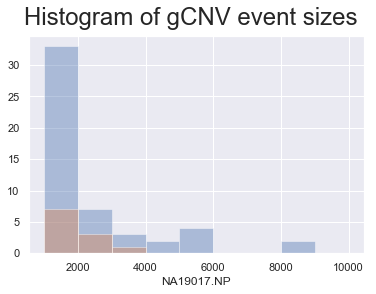

In [26]:
# Plot the size distribution as a histogram. Here, utilize the fact that NP represents the number of bins.
# An extension of this analysis would be to draw histograms of insertions versus deletions. 
binSize = 1000
events = gcnvVar['NA19017.NP']*binSize
sns.distplot(events, kde=False, bins=np.linspace(1000,10000,10))

# Overlay event sizes of concordant calls
eventsConcordant = gcnvConcordantVar['NA19017.NP']*binSize
sns.distplot(eventsConcordant, kde=False, bins=np.linspace(1000,10000,10))

plt.suptitle('Histogram of gCNV event sizes', fontsize=24)

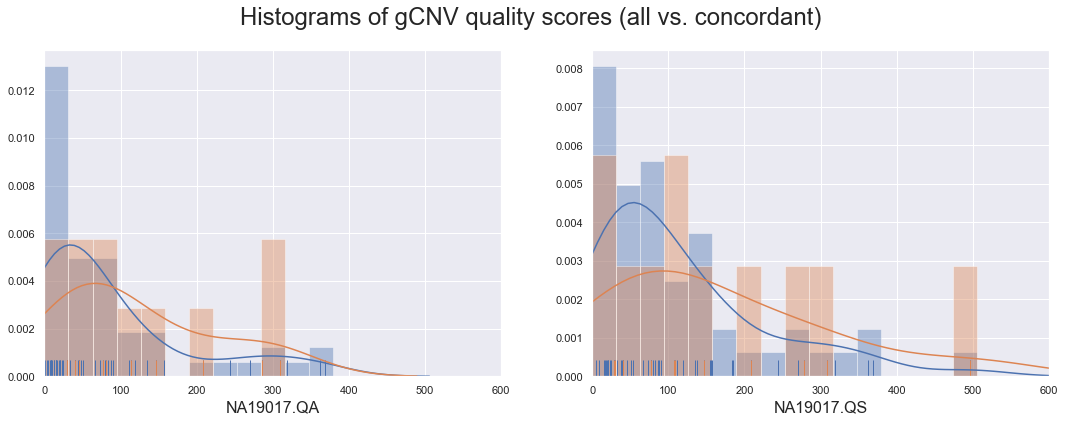

In [27]:
# Similarly plot the quality scores QA and QS.
fig, axs = plt.subplots(1,2, figsize=(18,6))
qa = gcnvVar['NA19017.QA']
qs = gcnvVar['NA19017.QS']
sns.distplot(qa, ax=axs[0], bins=np.linspace(0,600,20), rug=True)
sns.distplot(qs, ax=axs[1], bins=np.linspace(0,600,20), rug=True)
axs[0].set_xlabel('QA', fontsize = 16)
axs[1].set_xlabel('QS', fontsize = 16)
plt.suptitle('Histograms of gCNV quality scores (all vs. concordant)', fontsize = 24)

axs[0].set_xlim(0,600)
axs[1].set_xlim(0,600)

# Overlay QA and QS histograms of concordant calls
qaConcordant = gcnvConcordantVar['NA19017.QA']
qsConcordant = gcnvConcordantVar['NA19017.QS']
sns.distplot(qaConcordant, ax=axs[0], bins=np.linspace(0,600,20), rug=True)
sns.distplot(qsConcordant, ax=axs[1], bins=np.linspace(0,600,20), rug=True)

There is an ever-so-slight rightward shift in qualities for the concordant calls. 

> Could there be a correlation between event size and quality score?

<a name="3.2"></a>
### 3.2 Summarize metrics on gCNV calls by event type

In [28]:
# Collect some metrics
binSize = 1000
deletions = gcnvVar.loc[gcnvVar['NA19017.CN'] < 2]
insertions = gcnvVar.loc[gcnvVar['NA19017.CN'] > 2]

gcnvVarSummary = pd.DataFrame([np.count_nonzero(gcnvVar['NA19017.CN'] == 0)], columns=['cn0'])
gcnvVarSummary['cn1'] = np.count_nonzero(gcnvVar['NA19017.CN'] == 1)
gcnvVarSummary['cn3'] = np.count_nonzero(gcnvVar['NA19017.CN'] == 3)
gcnvVarSummary['cn4'] = np.count_nonzero(gcnvVar['NA19017.CN'] == 4)
gcnvVarSummary['cn5'] = np.count_nonzero(gcnvVar['NA19017.CN'] == 5)
gcnvVarSummary['n-total'] = len(gcnvVar.index)
gcnvVarSummary['n-dels'] = gcnvVarSummary['cn0'] + gcnvVarSummary['cn1']
gcnvVarSummary['n-amps'] = gcnvVarSummary['cn3'] + gcnvVarSummary['cn4'] + gcnvVarSummary['cn5']
gcnvVarSummary['bases-dels'] = deletions['NA19017.NP'].sum()*binSize
gcnvVarSummary['bases-amps'] = insertions['NA19017.NP'].sum()*binSize
gcnvVarSummary['avg-del-size'] = round(gcnvVarSummary['bases-dels'] / gcnvVarSummary['n-dels']).astype(int)
gcnvVarSummary['avg-amp-size'] = round(gcnvVarSummary['bases-amps'] / gcnvVarSummary['n-amps']).astype(int)
gcnvVarSummary['at1kb'] = len(gcnvVar[gcnvVar['NA19017.NP'] == 1])
gcnvVarSummary['fractionAt1kb'] = gcnvVarSummary['at1kb']/len(gcnvVar[gcnvVar['NA19017.NP'] >= 1])
    
gcnvVarSummary

,cn0,cn1,cn3,cn4,cn5,n-total,n-dels,n-amps,bases-dels,bases-amps,avg-del-size,avg-amp-size,at1kb,fractionAt1kb
0,19,26,4,2,0,51,45,6,72000,28000,1600,4667,33,0.647059


Over half of the events are exactly at 1kbp, the coverage bin size.  Most of the events are deletions. The next notebook analysis, [Notebook#11686](), examines gCNV callset annotations using bigger data.